### Import libraries

In [45]:
import numpy as np
import pandas as pd
import networkx as nx
import requests
import time
import os
import matplotlib.pyplot as plt
import itertools
import community.community_louvain as community_louvain
import re
from networkx.algorithms import bipartite
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from collections import Counter
import matplotlib.patheffects as pe
from fa2_modified import ForceAtlas2
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
import random

### Load data

Download the top 3 cast and overview of each movie

If you have the 'movie_cast_overview.csv' file already, you don't need to run this.

This document has already been in our submission. Please do not spend 50 minutes executing this cell.

In [18]:
API_KEY = "a1d579240045bb45c21c03bdc18a0f57"
OUTPUT_FILE = "movie_cast_overview.csv"
WORKERS = 6

def get_data(tmdb_id):
    url = f"https://api.themoviedb.org/3/movie/{tmdb_id}?api_key={API_KEY}&append_to_response=credits"
    
    for _ in range(3):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                
                # 1. Overview
                overview = data.get('overview', "").replace("\n", " ").replace("\r", " ").strip()
                
                # 2. Extract Top 3 Cast
                credits = data.get('credits', {})
                cast_list = credits.get('cast', [])
                top_actors = []
                for member in cast_list[:3]: # Keeping Top 3
                    clean_name = member['name'].replace(" ", "")
                    top_actors.append(clean_name)
                cast_string = " ".join(top_actors)
                
                return cast_string, overview
                
            elif response.status_code == 429:
                time.sleep(2)
                continue
            else:
                return "", ""
        except requests.exceptions.RequestException:
            return "", ""
    return "", ""

# --- MAIN EXECUTION ---
if not os.path.exists('links.csv'):
    print("❌ Error: links.csv not found.")
else:
    links = pd.read_csv("links.csv").dropna(subset=["tmdbId"])
    links['tmdbId'] = links['tmdbId'].astype(int).astype(str)
    
    total = len(links)
    results = []
    
    print(f"🚀 Starting fetch for {total} movies...")
    start_time = time.time()

    with ThreadPoolExecutor(max_workers=WORKERS) as executor:
        futures = {executor.submit(get_data, tmdb_id): mid for mid, tmdb_id in zip(links['movieId'], links['tmdbId'])}
        
        # The standard tqdm works without ipywidgets
        for i, future in tqdm(enumerate(as_completed(futures)), total=total, desc="Downloading"):
            movie_id = futures[future]
            try:
                cast_string, overview_string = future.result()
                results.append((movie_id, cast_string, overview_string))
            except Exception:
                results.append((movie_id, "", ""))

            # Save every 1000 movies
            if (i + 1) % 1000 == 0:
                temp_df = pd.DataFrame(results, columns=["movieId", "cast", "overview"])
                temp_df.to_csv(OUTPUT_FILE, index=False)
            
            time.sleep(0.01)

    # Final Save
    df = pd.DataFrame(results, columns=["movieId", "cast", "overview"])
    df.to_csv(OUTPUT_FILE, index=False)

    elapsed = time.time() - start_time
    print(f"✅ Done! Saved to {OUTPUT_FILE}")
    print(f"⏱️ Total time: {elapsed/60:.2f} minutes")

🚀 Starting fetch for 9734 movies...


Downloading: 100%|██████████| 9734/9734 [55:16<00:00,  2.93it/s]

✅ Done! Saved to movie_cast_overview.csv
⏱️ Total time: 55.29 minutes


In [24]:
# 1. Load the original MovieLens Data
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')

# 2. Load the NEW Cast & Overview Data
# We load the new file that contains both cast and overview
cast_overview = pd.read_csv('movie_cast_overview.csv').fillna('')

# 3. Process Tags (Merge multiple tags for one movie into a single string)
tags['tag'] = tags['tag'].astype(str)
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# 4. Merge everything into Master DataFrame
# Merge movies + tags
movies_meta = pd.merge(movies, tags_grouped, on='movieId', how='left')

# Merge + Cast & Overview
movies_meta = pd.merge(movies_meta, cast_overview, on='movieId', how='left')

# Fill any remaining missing values
movies_meta = movies_meta.fillna('')

# 5. Build the "Rich Text" for every movie
# This combines: Genres (x2 weight) + User Tags + Plot Summary
# This will make your Word Clouds much more detailed!
movies_meta['rich_text'] = (
    movies_meta['genres'].str.replace('|', ' ') + " " + 
    movies_meta['genres'].str.replace('|', ' ') + " " + 
    movies_meta['tag'] + " " + 
    movies_meta['overview']
)

# Filter: Drop movies that have no cast (cannot link them in the network)
movies_meta = movies_meta[movies_meta['cast'] != '']


print(f"Data loaded successfully.")
print(f"Total movies with Cast & Plot: {len(movies_meta)}")


# Preview
movies_meta.head(3)

Data loaded successfully.
Total movies with Cast & Plot: 9588


,movieId,title,genres,tag,cast,overview,rich_text
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun,TomHanks TimAllen DonRickles,"Led by Woody, Andy's toys live happily in his ...",Adventure Animation Children Comedy Fantasy Ad...
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game Robin Williams game,RobinWilliams KirstenDunst BradleyPierce,When siblings Judy and Peter discover an encha...,Adventure Children Fantasy Adventure Children ...
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old,WalterMatthau JackLemmon Ann-Margret,A family wedding reignites the ancient feud be...,Comedy Romance Comedy Romance moldy old A fami...


### Build the Network

In [25]:
G = nx.Graph()
actor_corpus = {} # Key: Actor Name, Value: List of strings (Rich Text)

# Loop through every movie
for index, row in movies_meta.iterrows():
    cast_str = row['cast']
    
    # Double check
    if not cast_str:
        continue
        
    # Get actors (Order is already preserved from your download script)
    # We split by space to get the list of names
    actors = cast_str.split(" ")
    
    # 1. Build the Corpus
    # We use the 'rich_text' column we created in Step 1
    # This ensures 'actor_corpus' includes the Movie Plot Summary
    text = row['rich_text']
    
    for actor in actors:
        if actor not in actor_corpus:
            actor_corpus[actor] = []
        actor_corpus[actor].append(text)
        
    # 2. Build the Graph Edges
    if len(actors) > 1:
        for u, v in itertools.combinations(actors, 2):
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1
            else:
                G.add_edge(u, v, weight=1)

# Remove Self Loops & Isolates
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))

print(f"Raw Graph: {G.number_of_nodes()} Actors, {G.number_of_edges()} Links")

# Extract Giant Component
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

print(f"Giant Component (G_lcc): {G_lcc.number_of_nodes()} Nodes, {G_lcc.number_of_edges()} Edges")

Raw Graph: 11034 Actors, 26860 Links
Giant Component (G_lcc): 7720 Nodes, 23357 Edges


Average Co-Stars per Actor: 6.05


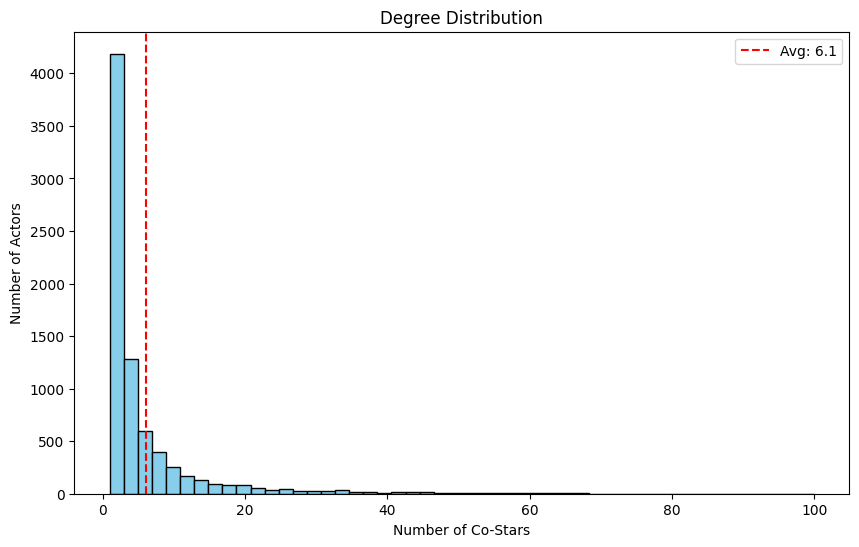

Calculating Centrality...

Top 10 Actors by Degree Centrality (Most Co-Stars):
  RobertDeNiro: 0.0130
  BruceWillis: 0.0126
  NicolasCage: 0.0119
  SamuelL.Jackson: 0.0113
  JeffBridges: 0.0105
  TomHanks: 0.0104
  JohnnyDepp: 0.0104
  RobinWilliams: 0.0101
  MorganFreeman: 0.0098
  DennisQuaid: 0.0096


In [26]:
# A. Degree Distribution
degrees = [d for n, d in G_lcc.degree()]
avg_degree = sum(degrees) / len(degrees)

print(f"Average Co-Stars per Actor: {avg_degree:.2f}")

plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, color='skyblue', edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Number of Co-Stars")
plt.ylabel("Number of Actors")
plt.axvline(avg_degree, color='red', linestyle='dashed', label=f'Avg: {avg_degree:.1f}')
plt.legend()
plt.show()

# B. Centrality (Who runs Hollywood?)
# We use Degree (Popularity)
print("Calculating Centrality...")
degree_cent = nx.degree_centrality(G_lcc)

# Print Top 10 Most Connected Actors
sorted_cent = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print(f"\nTop 10 Actors by Degree Centrality (Most Co-Stars):")
for actor, score in sorted_cent:
    print(f"  {actor}: {score:.4f}")

### Community Detection

In [27]:
# 1. Run Louvain on the Full Giant Component
partition = community_louvain.best_partition(G_lcc, random_state=42)
modularity = community_louvain.modularity(partition, G_lcc)

print(f"Network Modularity: {modularity:.3f}")
print(f"Detected {len(set(partition.values()))} communities.")

# 2. Save partition to node attributes (useful if we export to Gephi later)
nx.set_node_attributes(G_lcc, partition, "community")

# 3. Quick Look: Who are the biggest communities?
counts = Counter(partition.values())
print("\nTop 10 Largest Communities:")
for comm_id, size in counts.most_common(10):
    # Find the most connected actor in this specific community to identify it
    actors_in_comm = [n for n in G_lcc.nodes() if partition[n] == comm_id]
    boss = max(actors_in_comm, key=lambda n: G_lcc.degree(n))
    print(f"  Community {comm_id}: {size} actors. (Central: {boss})")

Network Modularity: 0.570
Detected 110 communities.

Top 10 Largest Communities:
  Community 1: 1140 actors. (Central: JohnnyDepp)
  Community 0: 1069 actors. (Central: RobertDeNiro)
  Community 2: 903 actors. (Central: CaryGrant)
  Community 12: 327 actors. (Central: GérardDepardieu)
  Community 16: 206 actors. (Central: JackieChan)
  Community 34: 205 actors. (Central: TatsuyaNakadai)
  Community 11: 201 actors. (Central: AdamSandler)
  Community 3: 197 actors. (Central: KeanuReeves)
  Community 7: 189 actors. (Central: MelGibson)
  Community 17: 176 actors. (Central: SteveGuttenberg)


### Disparity Filter Backbone (α = 0.2)

We extracted the network backbone using the Disparity Filter algorithm (Serrano et al., 2009) with a significance level of 
α=0.2
 to preserve structural heterogeneity.

In [31]:
def get_disparity_backbone(G, alpha=0.05):
    # Create a new graph for the backbone
    Backbone = nx.Graph()
    
    # Iterate over every node to calculate significance of its edges
    for u in G.nodes():
        k = G.degree(u)
        if k > 1:
            # Sum of weights for node u
            strength = sum(w['weight'] for v, w in G[u].items())
            
            for v, w in G[u].items():
                weight = w['weight']
                # Normalized weight
                p_ij = float(weight) / strength
                # Probability calculation (Disparity Filter Formula)
                alpha_ij = (1 - p_ij) ** (k - 1)
                
                if alpha_ij < alpha:
                    Backbone.add_edge(u, v, weight=weight)
    return Backbone

# 1. Run the Filter on the Full Giant Component
G_visual = get_disparity_backbone(G_lcc, alpha=0.2)

# 2. Clean up (Remove isolates and keep largest component of the backbone)
G_visual.remove_nodes_from(list(nx.isolates(G_visual)))
largest_cc = max(nx.connected_components(G_visual), key=len)
G_visual = G_visual.subgraph(largest_cc).copy()

# 3. Run Community Detection on this Backbone
# We re-calculate communities here to see how the BACKBONE specifically clusters
partition_backbone = community_louvain.best_partition(G_visual, random_state=42)
modularity = community_louvain.modularity(partition_backbone, G_visual)

# 4. Print Stats
print(f"Original Edges: {G_lcc.number_of_edges()}")
print("-" * 30)
print(f"Backbone Nodes: {G_visual.number_of_nodes()}")
print(f"Backbone Edges: {G_visual.number_of_edges()}")
print(f"Backbone Modularity: {modularity:.3f}")
print(f"Detected Communities: {len(set(partition_backbone.values()))}")

Original Edges: 23357
------------------------------
Backbone Nodes: 382
Backbone Edges: 465
Backbone Modularity: 0.860
Detected Communities: 20


### Visualizing the Network (Backbone network)

Calculating ForceAtlas2 layout


100%|██████████| 2000/2000 [00:08<00:00, 240.96it/s]


BarnesHut Approximation  took  1.78  seconds
Repulsion forces  took  5.80  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.05  seconds
AdjustSpeedAndApplyForces step  took  0.23  seconds
Labeling Top 15 Influencers...


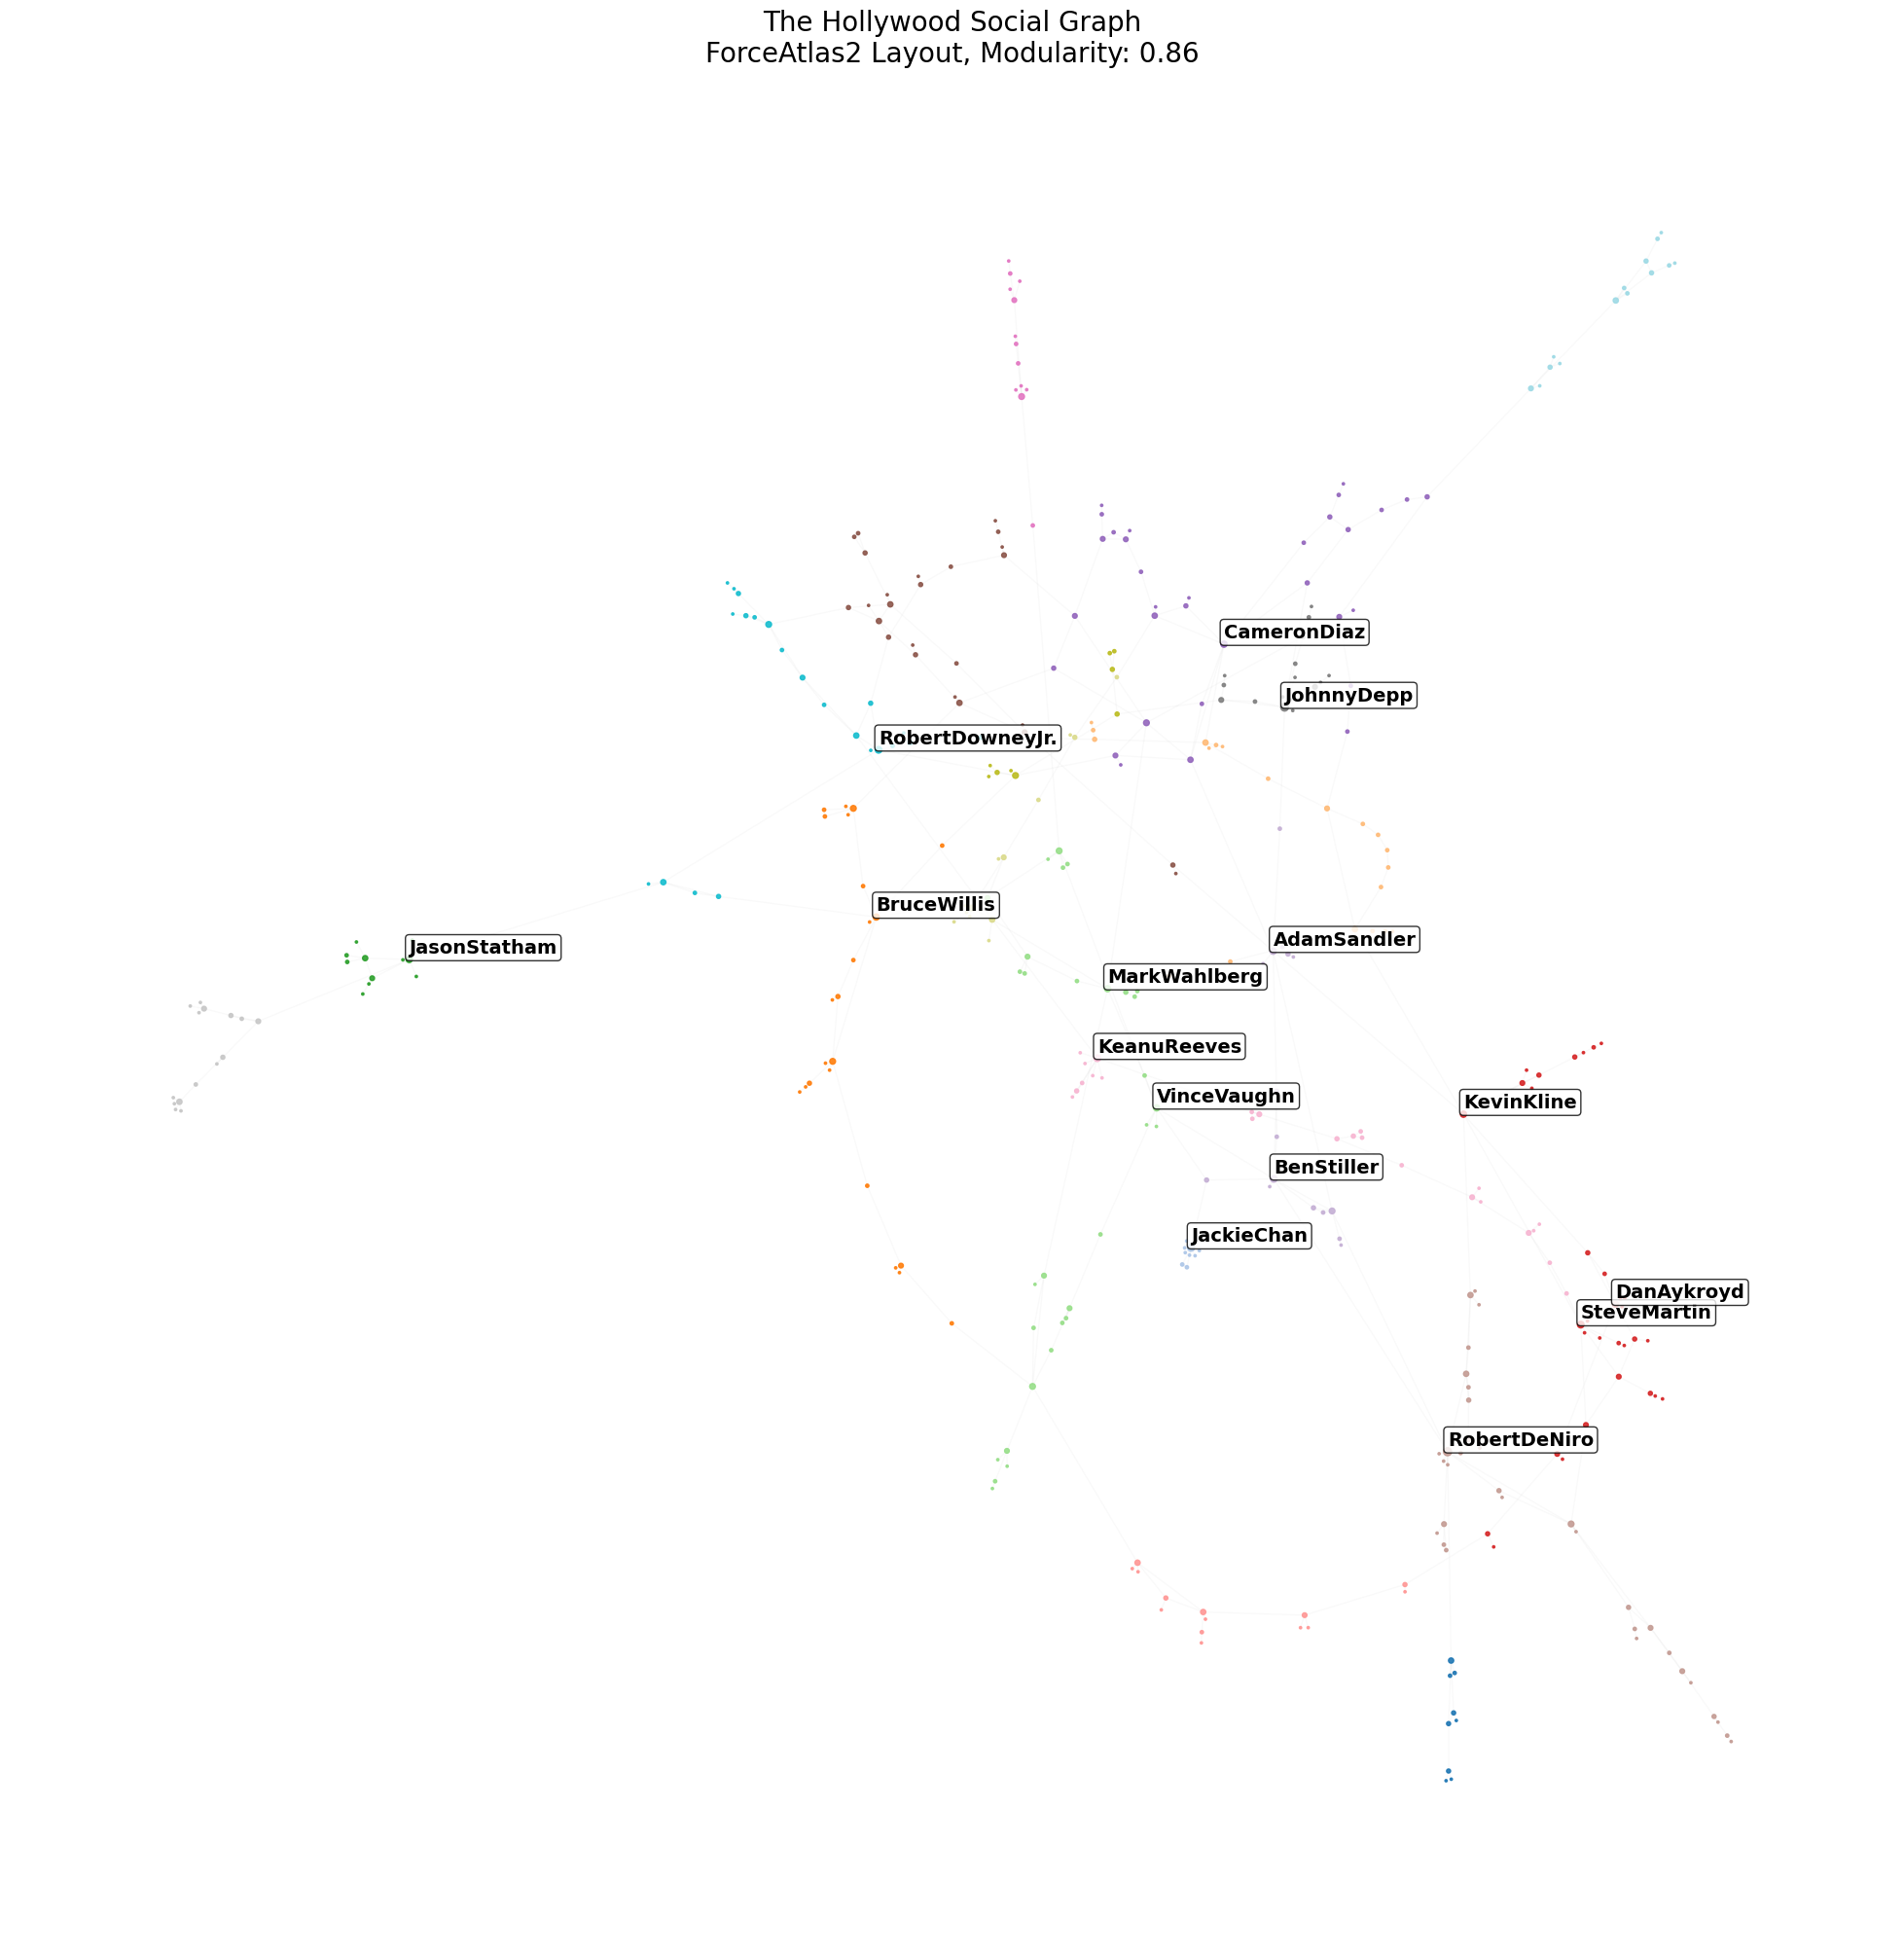

In [32]:
plt.figure(figsize=(25, 25))

# 1. Setup ForceAtlas2 Parameters
# These settings help spread out the "Hairball" into distinct clusters
forceatlas2 = ForceAtlas2(
    # Behavior
    outboundAttractionDistribution=True,  # Distributes attraction along degree (good for hubs)
    linLogMode=False,  # Linear repulsion
    adjustSizes=False,  # Prevent overlap (approximate)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # Keep false for safety in notebooks

    # Tuning
    scalingRatio=2.0,
    gravity=1.0,
    verbose=True
)

# 2. Calculate Layout
# This takes the G_visual backbone graph from the previous cell
print("Calculating ForceAtlas2 layout")
pos = forceatlas2.forceatlas2_networkx_layout(G_visual, pos=None, iterations=2000)

# 3. Prepare Colors
# Use the partition calculated on the backbone in the previous cell
node_colors = [partition_backbone[n] for n in G_visual.nodes()]

# 4. Draw Network
# Draw Edges (Faint)
nx.draw_networkx_edges(G_visual, pos, alpha=0.05, edge_color='#999999')

# Draw Nodes (Sized by Degree)
d = dict(G_visual.degree())
node_sizes = [v * 3 for v in d.values()]

nx.draw_networkx_nodes(G_visual, pos, 
                       node_size=node_sizes, 
                       cmap=plt.get_cmap('tab20'), 
                       node_color=node_colors, 
                       alpha=0.9)

# 5. Label the Top Influencers
# We label the top 15 most connected actors in this backbone
print("Labeling Top 15 Influencers...")
sorted_degree = sorted(d.items(), key=lambda x: x[1], reverse=True)[:15]

for actor, degree in sorted_degree:
    if actor in pos:
        x, y = pos[actor]
        plt.text(x, y+5, actor, fontsize=14, fontweight='bold', color='black',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.2'))

plt.title(f"The Hollywood Social Graph\nForceAtlas2 Layout, Modularity: {modularity:.2f}", fontsize=20)
plt.axis('off')
plt.show()

### NLP & TF-IDF

Text Aggregation & TF-IDF Calculation

In [35]:
# 1. Create a "Nuclear" Stop Word List
# We want to ban actor names and generic movie terms so we only see descriptive words.
actor_name_parts = set()
for node in G_visual.nodes():
    # Split names into parts ("Jean-Claude Van Damme" -> "jean", "claude", "van", "damme")
    parts = re.split(r'[^a-zA-Z]', str(node).lower())
    for p in parts:
        if len(p) > 2: # Ignore initials
            actor_name_parts.add(p)

# Add generic film terms to the ban list
generic_terms = {
    'movie', 'film', 'story', 'character', 'role', 'cast', 'director', 
    'plot', 'scene', 'performance', 'star', 'acting', 'time', 'life',
    'series', 'version', 'best', 'good', 'great', 'new', 'world'
}

# Combine everything
my_stop_words = list(ENGLISH_STOP_WORDS.union(actor_name_parts).union(generic_terms))

# 2. Aggregate Text per Community
# We iterate through the actors in the Visual Backbone (G_visual)
comm_docs = {} 

for actor in G_visual.nodes():
    # Which tribe does this actor belong to?
    comm_id = partition_backbone[actor]
    
    # Get their movie text history
    if actor in actor_corpus:
        # Join all their individual movie strings into one giant string
        actor_text = " ".join(actor_corpus[actor])
        
        # Append to the community's collective document
        comm_docs[comm_id] = comm_docs.get(comm_id, "") + " " + actor_text

print(f"Successfully aggregated text for {len(comm_docs)} communities.")

# 3. Calculate TF-IDF
print("Calculating TF-IDF scores...")

tfidf_vectorizer = TfidfVectorizer(
    stop_words=my_stop_words, # Use our custom list
    max_df=0.6,               # Ignore words appearing in >60% of tribes (too common)
    min_df=2,                 # Ignore unique typos
    max_features=1000         # Keep top 1000 words
)

# Fit the model
tfidf_matrix = tfidf_vectorizer.fit_transform(comm_docs.values())
feature_names = tfidf_vectorizer.get_feature_names_out()

print("✓ TF-IDF Calculation Complete.")

Successfully aggregated text for 20 communities.
Calculating TF-IDF scores...
✓ TF-IDF Calculation Complete.


Generating the Word Clouds

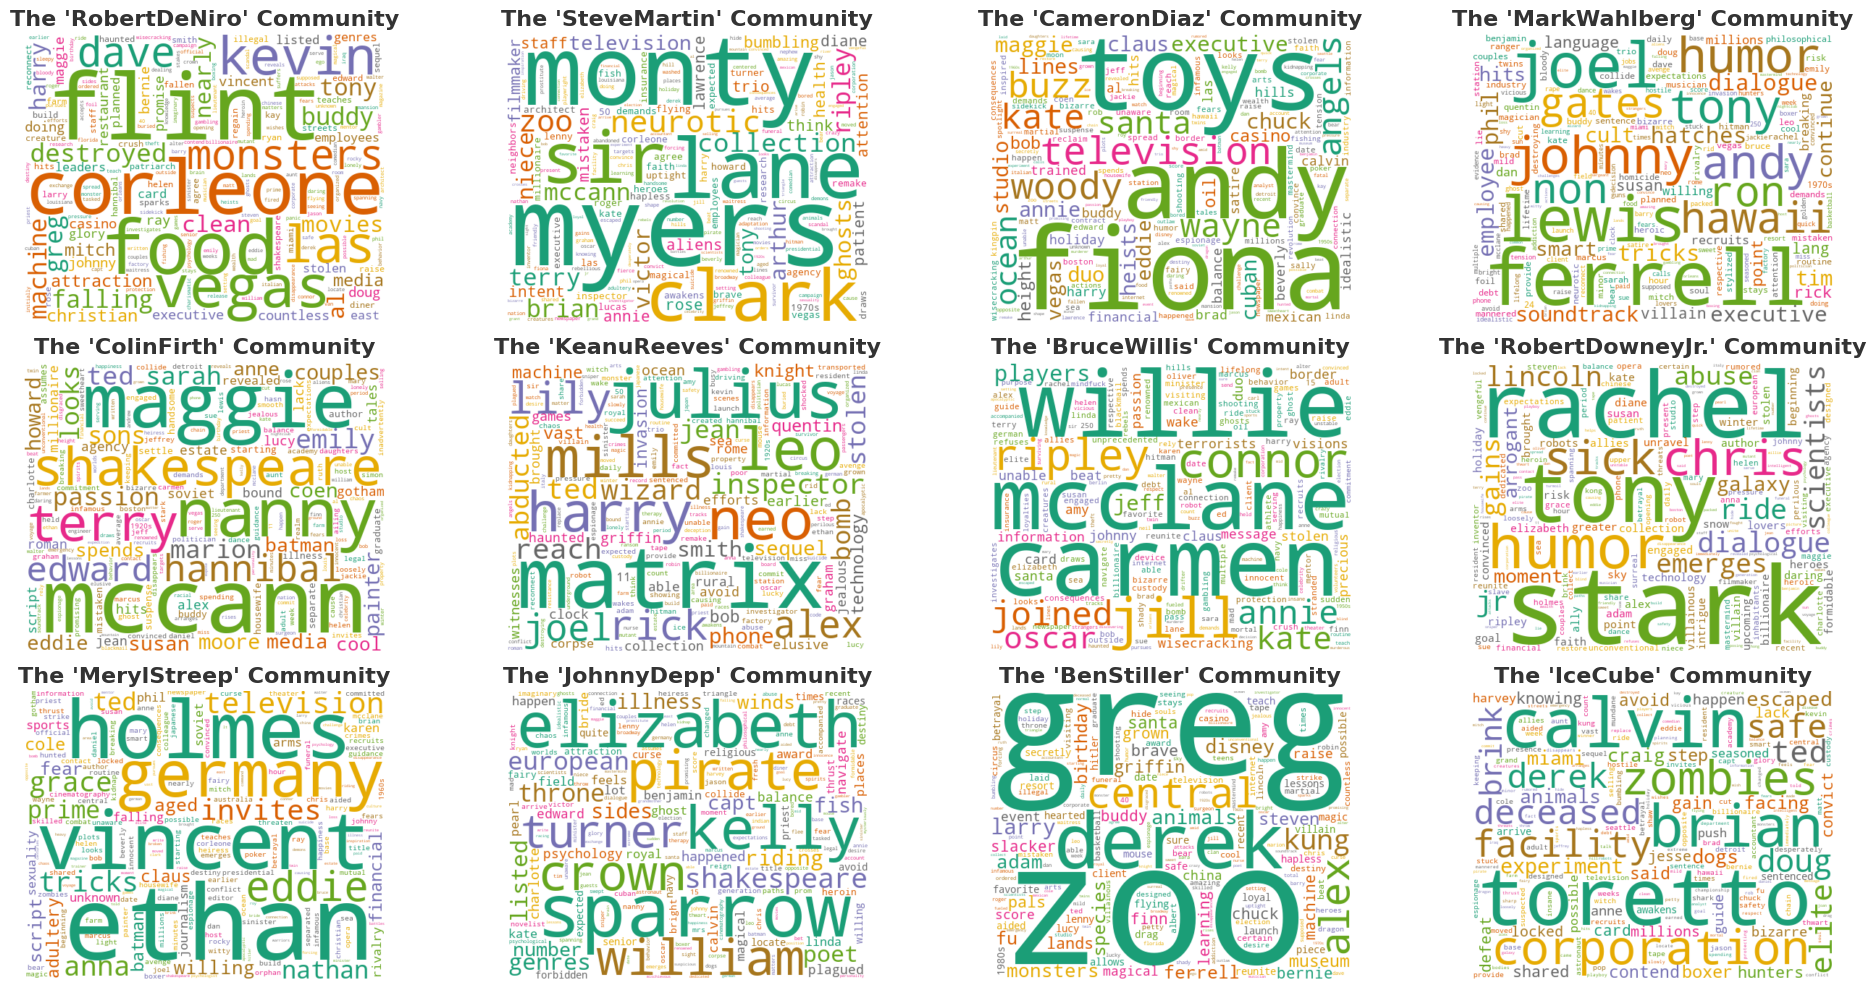

In [36]:
# 1. Identify the Top 12 Largest Communities in the Backbone
# We count how many actors are in each community ID
comm_counts = Counter([partition_backbone[n] for n in G_visual.nodes()])
top_12_comms = [c for c, count in comm_counts.most_common(12)]

# A list of all community IDs in the order the Vectorizer sees them
sorted_comm_ids = list(comm_docs.keys())

# 2. Plotting
plt.figure(figsize=(20, 10))

for i, comm_id in enumerate(top_12_comms):
    try:
        # Find the row index for this community in the TF-IDF matrix
        matrix_idx = sorted_comm_ids.index(comm_id)
        
        # Extract the scores for this row
        scores = tfidf_matrix[matrix_idx].T.todense().tolist()
        scores = [s[0] for s in scores]
        
        # Create a dictionary {Word: Score} for the WordCloud generator
        word_score_dict = dict(zip(feature_names, scores))
        
        # Generate Cloud
        wc = WordCloud(
            background_color='white', 
            width=500, 
            height=400, 
            colormap='Dark2',
            random_state=42
        ).generate_from_frequencies(word_score_dict)
        
        # Find the "Boss" actor (Central Node) to name the tribe
        actors_in_comm = [n for n in G_visual.nodes() if partition_backbone[n] == comm_id]
        boss = max(actors_in_comm, key=lambda n: G_visual.degree(n))
        
        # Plot
        plt.subplot(3, 4, i+1)
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f"The '{boss}' Community", fontsize=16, fontweight='bold', color='#333')
        plt.axis('off')
        
    except ValueError:
        continue

plt.tight_layout()
plt.show()

### The Findings

Finding A: Structural Role (Community-Based)

Calculating centrality measures...

COMMUNITY    | KING (Popular)       | AMBASSADORS (Connector)   | SCORE
---------------------------------------------------------------------------
Community 11     | RobertDeNiro         | RobertDeNiro              | 0.2181
Community 6      | SteveMartin          | KevinKline                | 0.1488
Community 8      | CameronDiaz          | GeorgeClooney             | 0.2005
Community 5      | MarkWahlberg         | MarkWahlberg              | 0.2497
Community 10     | ColinFirth           | AnthonyHopkins            | 0.0796
Community 13     | KeanuReeves          | KeanuReeves               | 0.0860
Community 2      | BruceWillis          | BruceWillis               | 0.1227
Community 18     | RobertDowneyJr.      | RobertDowneyJr.           | 0.1503
Community 3      | MerylStreep          | MerylStreep               | 0.0980
Community 14     | JohnnyDepp           | JohnnyDepp                | 0.0778
Community 9      | BenStiller           | Adam

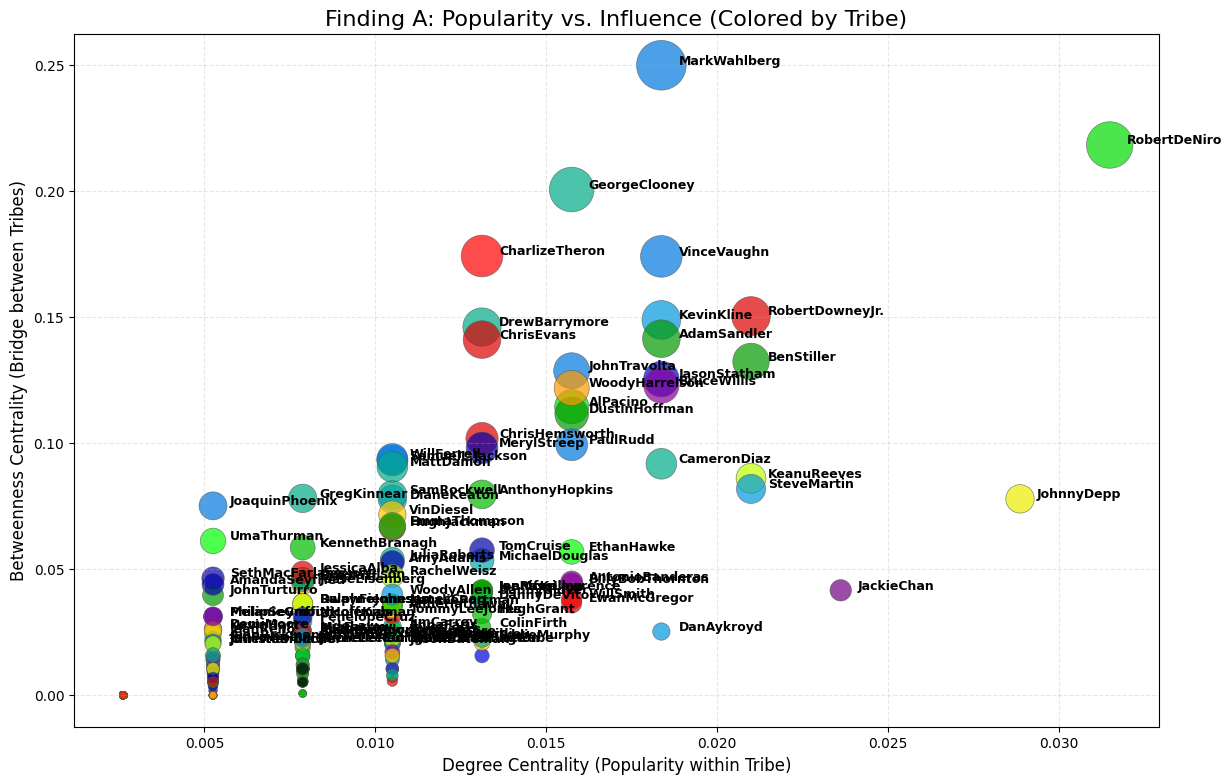

In [43]:
# 1. Calculate Centrality on the Backbone
# We use the Disparity Backbone (G_visual) because it represents the "Real" social structure
print("Calculating centrality measures...")
deg_cent = nx.degree_centrality(G_visual)
bet_cent = nx.betweenness_centrality(G_visual)

# 2. Organize Data by Community
community_bridges = {}
all_community_ids = set(partition_backbone.values())

for comm_id in all_community_ids:
    # Get actors in this community
    actors_in_comm = [n for n in G_visual.nodes() if partition_backbone[n] == comm_id]
    
    if not actors_in_comm:
        continue
        
    # Find the "Ambassador" (Max Betweenness)
    # This is the person who connects their tribe to the outside world
    ambassador = max(actors_in_comm, key=lambda n: bet_cent[n])
    
    # Find the "King" (Max Degree) - usually the most famous person
    king = max(actors_in_comm, key=lambda n: deg_cent[n])
    
    community_bridges[comm_id] = {
        'ambassador': ambassador,
        'king': king,
        'betweenness': bet_cent[ambassador],
        'degree': deg_cent[ambassador],
        'size': len(actors_in_comm)
    }

# 3. Print the Findings Table
print(f"\n{'COMMUNITY':<12} | {'KING (Popular)':<20} | {'AMBASSADORS (Connector)':<25} | {'SCORE'}")
print("-" * 75)

# Sort by community size
sorted_comms = sorted(community_bridges.items(), key=lambda x: x[1]['size'], reverse=True)

for comm_id, data in sorted_comms[:15]: # Show top 15 groups
    print(f"Community {comm_id:<6} | {data['king']:<20} | {data['ambassador']:<25} | {data['betweenness']:.4f}")

# 4. VISUALIZATION: Colored Scatter Plot
x_deg = []
y_bet = []
colors = []
sizes = []
labels = []

# Prepare Colors
cmap = plt.get_cmap('nipy_spectral')
comm_list = list(all_community_ids)

for node in G_visual.nodes():
    x_deg.append(deg_cent[node])
    y_bet.append(bet_cent[node])
    
    # Color by Tribe
    comm_id = partition_backbone[node]
    colors.append(cmap(comm_list.index(comm_id) / len(comm_list)))
    
    # Size by Influence
    sizes.append(30 + (bet_cent[node] * 5000))
    
    # Label Logic:
    # 1. Is this person the Ambassador of a decent-sized group?
    is_ambassador = (community_bridges[comm_id]['ambassador'] == node)
    is_decent_size = (community_bridges[comm_id]['size'] > 10) 
    
    # 2. Is this person a Global Super-Connector?
    is_super_connector = (bet_cent[node] > 0.02)
    
    if (is_ambassador and is_decent_size) or is_super_connector:
        labels.append((deg_cent[node], bet_cent[node], node))

plt.figure(figsize=(14, 9))
plt.scatter(x_deg, y_bet, c=colors, s=sizes, alpha=0.7, edgecolor='#555555', linewidth=0.5)

# Add text labels
for lx, ly, lname in labels:
    # Add a tiny jitter to text so they don't overlap perfectly
    plt.text(lx + 0.0005, ly + 0.0005, lname, fontsize=9, fontweight='bold')

plt.title("Finding A: Popularity vs. Influence (Colored by Tribe)", fontsize=16)
plt.xlabel("Degree Centrality (Popularity within Tribe)", fontsize=12)
plt.ylabel("Betweenness Centrality (Bridge between Tribes)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Finding B: Emotional spectrum

Scanning 20 communities...


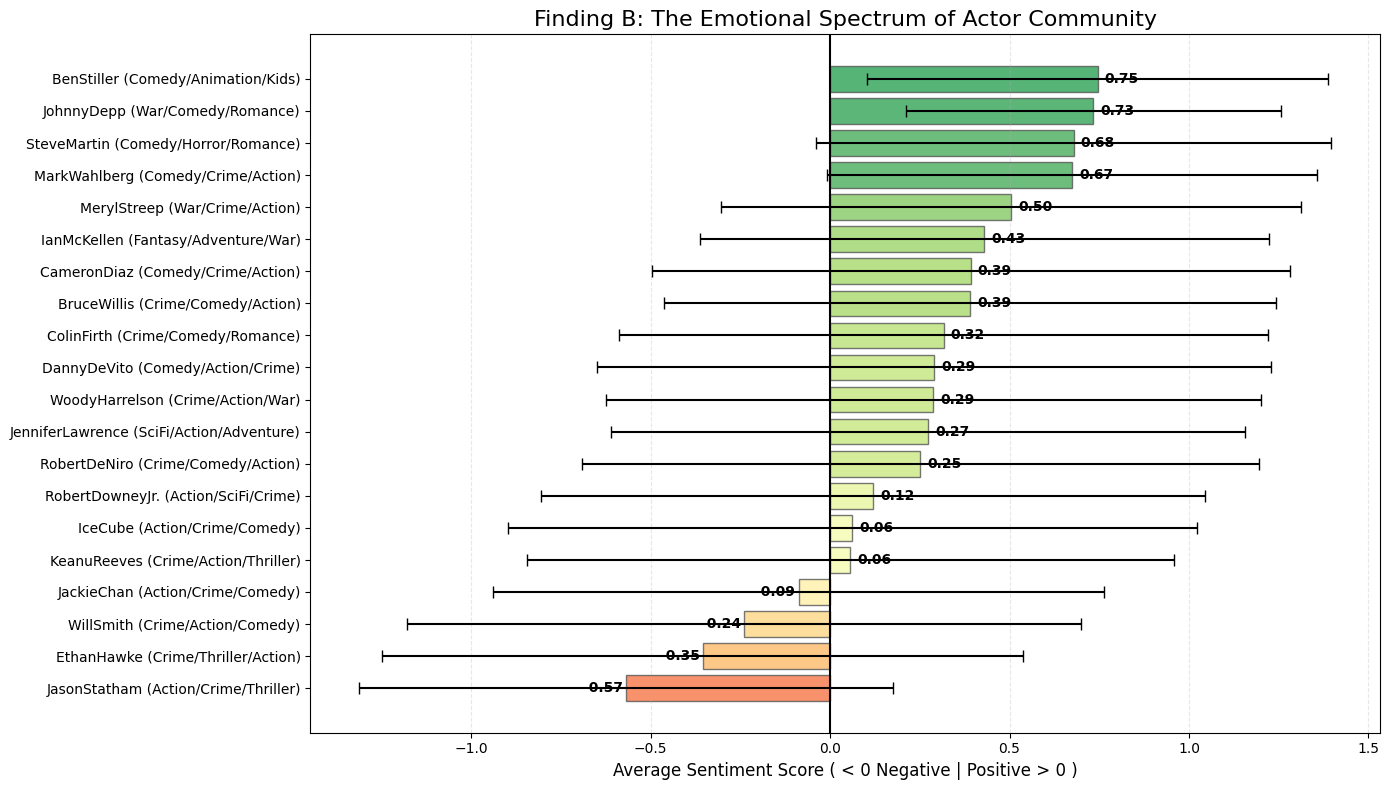

In [ ]:
sia = SentimentIntensityAnalyzer()
community_stats = []

# Get ALL communities from the backbone
all_community_ids = set(partition_backbone.values())

# Weighted Scoring System
genre_weights = {
    'film-noir': 5, 'documentary': 5, 'animation': 4, 'western': 4, 'musical': 4,
    'horror': 3, 'war': 3, "children's": 3, 'children': 3,
    'fantasy': 2.5, 'crime': 2.5, 'mystery': 2, 'sci-fi': 2,
    'action': 1.5, 'adventure': 1.5, 'thriller': 1.2, 'romance': 1.2,
    'comedy': 1.0, 'drama': 0.5
}

# Mapping lowercase keys to Display Names
display_map = {
    'film-noir': 'Noir', 'documentary': 'Doc', 'animation': 'Animation',
    'western': 'Western', 'musical': 'Musical', 'horror': 'Horror',
    'war': 'War', "children's": 'Kids', 'children': 'Kids',
    'fantasy': 'Fantasy', 'crime': 'Crime', 'mystery': 'Mystery',
    'sci-fi': 'SciFi', 'action': 'Action', 'adventure': 'Adventure',
    'thriller': 'Thriller', 'romance': 'Romance', 'comedy': 'Comedy',
    'drama': 'Drama'
}

print(f"Scanning {len(all_community_ids)} communities...")

for comm_id in all_community_ids:
    # Get actors in this community (Backbone only)
    actors_in_comm = [n for n in G_visual.nodes() if partition_backbone[n] == comm_id]
    
    # FILTER: Skip tiny communities to keep the chart clean
    if len(actors_in_comm) < 5:
        continue
    
    # 1. Sentiment Calculation
    actor_scores = []
    all_text_blob = ""
    
    for actor in actors_in_comm:
        if actor in actor_corpus:
            # Get text (Genres + Tags + Overview)
            text = " ".join(actor_corpus[actor])
            all_text_blob += text + " "
            
            # Score this specific actor
            score = sia.polarity_scores(text[:10000])['compound']
            actor_scores.append(score)
    
    if not actor_scores:
        continue

    avg_score = np.mean(actor_scores)
    std_dev = np.std(actor_scores)
    
    # 2. Find the "Boss" (Central Actor)
    boss = max(actors_in_comm, key=lambda n: G_visual.degree(n))
    
    # 3. Find Top 3 Genres (Weighted)
    blob_lower = all_text_blob.lower()
    scores_list = []
    
    for key, weight in genre_weights.items():
        count = blob_lower.count(key)
        if count > 0:
            final_score = count * weight
            display_name = display_map.get(key, key.title())
            scores_list.append((final_score, display_name))
    
    # Sort by score descending
    scores_list.sort(key=lambda x: x[0], reverse=True)
    
    # Take Top 3 (remove duplicates)
    top_genres = []
    seen = set()
    for score, name in scores_list:
        if name not in seen:
            top_genres.append(name)
            seen.add(name)
        if len(top_genres) >= 3:
            break
            
    label_str = "/".join(top_genres) if top_genres else "General"

    community_stats.append({
        'label': f"{boss} ({label_str})",
        'mean': avg_score,
        'std': std_dev
    })

# Sort by Happiness (Sad -> Happy)
community_stats = sorted(community_stats, key=lambda x: x['mean'])

# --- VISUALIZATION ---
plot_height = max(8, len(community_stats) * 0.4) # Dynamic height
plt.figure(figsize=(14, plot_height))

labels = [x['label'] for x in community_stats]
means = [x['mean'] for x in community_stats]
errors = [x['std'] for x in community_stats]

# Colors (Red to Green)
# We normalize the scores (-1 to 1) to the colormap range (0 to 1)
norm_scores = (np.array(means) + 1) / 2
colors = plt.cm.RdYlGn(norm_scores)

bars = plt.barh(labels, means, xerr=errors, color=colors, capsize=4, alpha=0.8, edgecolor='#555555')

plt.axvline(0, color='black', linewidth=1.5, linestyle='-')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.title("Finding B: The Emotional Spectrum of Actor Community", fontsize=16)
plt.xlabel("Average Sentiment Score ( < 0 Negative | Positive > 0 )", fontsize=12)

# Add value labels
for i, v in enumerate(means):
    offset = 0.02 if v >= 0 else -0.12
    plt.text(v + offset, i, f"{v:.2f}", va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

Finding C: The "Narrative Homophily" Hypothesis

"Social connections in Hollywood are driven by Narrative Compatibility. Two actors are significantly more likely to work together if their 'Plot Vocabulary' is similar. We hypothesize that connected actors have a much higher Cosine Similarity in their text profiles than random pairs of actors."

Building individual actor vectors...
Calculating similarity for Real Connections...
Calculating similarity for Random Non-Connections...

Average Similarity (Friends): 0.3389
Average Similarity (Strangers): 0.1315


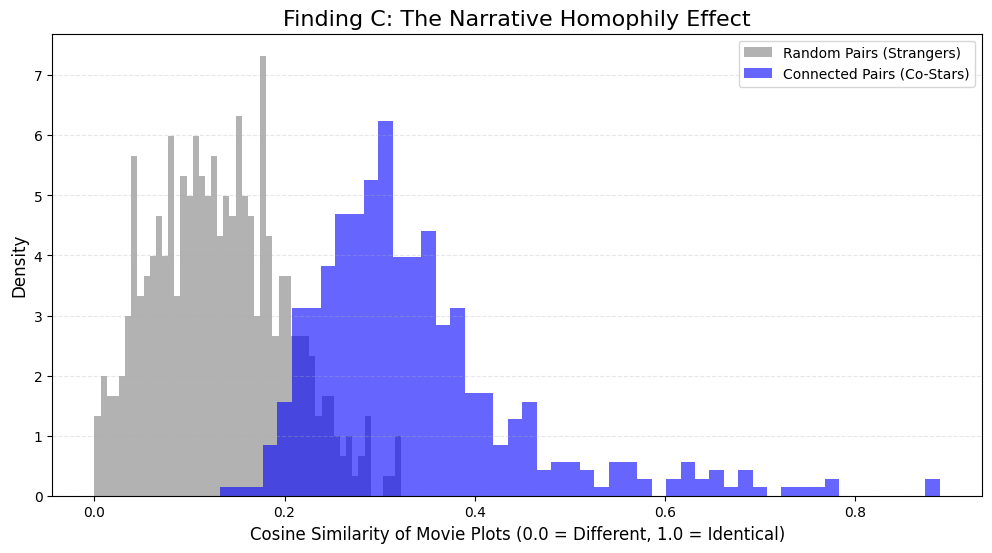

In [ ]:
# 1. Prepare Text per ACTOR (Not per community)
# We need to re-vectorize for individual actors in the backbone
print("Building individual actor vectors...")
actor_list = list(G_visual.nodes())
actor_docs = []

for actor in actor_list:
    if actor in actor_corpus:
        actor_docs.append(" ".join(actor_corpus[actor]))
    else:
        actor_docs.append("")

# 2. Run TF-IDF on Individuals
# We use a larger feature set to capture subtle plot details
tfidf_vec = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=2, max_features=1000)
tfidf_matrix = tfidf_vec.fit_transform(actor_docs)

# 3. Calculate Similarity for REAL Edges
print("Calculating similarity for Real Connections...")
real_similarities = []
edge_list = list(G_visual.edges())

# Create a mapping from Actor Name -> Matrix Index
actor_to_idx = {name: i for i, name in enumerate(actor_list)}

for u, v in edge_list:
    if u in actor_to_idx and v in actor_to_idx:
        idx_u = actor_to_idx[u]
        idx_v = actor_to_idx[v]
        
        # Compute cosine similarity between these two specific vectors
        # (Optimization: We slice the sparse matrix)
        sim = cosine_similarity(tfidf_matrix[idx_u], tfidf_matrix[idx_v])[0][0]
        real_similarities.append(sim)

# 4. Calculate Similarity for RANDOM Non-Edges (The Control Group)
print("Calculating similarity for Random Non-Connections...")
random_similarities = []
num_samples = len(real_similarities) # Compare equal sample sizes

while len(random_similarities) < num_samples:
    # Pick two random actors
    u, v = random.sample(actor_list, 2)
    
    # Ensure they are NOT connected
    if not G_visual.has_edge(u, v):
        idx_u = actor_to_idx[u]
        idx_v = actor_to_idx[v]
        sim = cosine_similarity(tfidf_matrix[idx_u], tfidf_matrix[idx_v])[0][0]
        random_similarities.append(sim)

# 5. Visualization & Statistics
print(f"\nAverage Similarity (Friends): {np.mean(real_similarities):.4f}")
print(f"Average Similarity (Strangers): {np.mean(random_similarities):.4f}")

plt.figure(figsize=(12, 6))

# Plot Histograms
plt.hist(random_similarities, bins=50, alpha=0.6, label='Random Pairs (Strangers)', color='gray', density=True)
plt.hist(real_similarities, bins=50, alpha=0.6, label='Connected Pairs (Co-Stars)', color='blue', density=True)

plt.title("Finding C: The Narrative Homophily Effect", fontsize=16)
plt.xlabel("Cosine Similarity of Movie Plots (0.0 = Different, 1.0 = Identical)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

The plot shows a clear right-shift for connected pairs, means actors who co-star tend to have acted in conceptually similar movies (higher plot similarity).